In [ ]:
import torch
import torchvision 
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

### 数据加载与预处理

In [ ]:
# Data preprocessing
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.1307], std=[0.3081])
])

# Load datasets
path = './data/'
trainData = torchvision.datasets.MNIST(path, train=True, transform=transform, download=True)
testData = torchvision.datasets.MNIST(path, train=False, transform=transform, download=True)

# Create DataLoaders
trainDataLoader = torch.utils.data.DataLoader(trainData, batch_size=256, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testData, batch_size=1000, shuffle=False)

print(f"训练集大小: {len(trainData)}")
print(f"测试集大小: {len(testData)}")

### 模型定义

In [ ]:
# Model definitions
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
class ResNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = torch.nn.ReLU()
        self.shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return self.relu(x + shortcut)
    
class CNNResNet(torch.nn.Module):
    def __init__(self):
        super(CNNResNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.resblock1 = ResNetBlock(64, 64)
        self.fc1 = torch.nn.Linear(64 * 28 * 28, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.resblock1(x)
        x = x.view(x.size(0), -1)
        return self.fc1(x)

In [ ]:
class RNN(torch.nn.Module):
    def __init__(self, input_size=28, hidden_size=128, num_layers=2, num_classes=10):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 28, 28)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

In [ ]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, embed_dim=256, num_heads=4, num_classes=10):
        super(MultiHeadAttention, self).__init__()
        # Increase embedding dimension and reduce num_heads for better stability
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        
        # Initial embedding layer with normalization and activation
        self.embedding = torch.nn.Sequential(
            torch.nn.Linear(28, embed_dim),
            torch.nn.LayerNorm(embed_dim),
            torch.nn.ReLU()
        )
        
        # Multi-head attention with dropout
        self.attention = torch.nn.MultiheadAttention(
            embed_dim=embed_dim, 
            num_heads=num_heads,
            dropout=0.1
        )
        
        # Layer normalization for stability
        self.norm1 = torch.nn.LayerNorm(embed_dim)
        
        # Feed-forward network with residual connection
        self.ffn = torch.nn.Sequential(
            torch.nn.Linear(embed_dim, embed_dim * 2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(embed_dim * 2, embed_dim)
        )
        
        # Final layer normalization
        self.norm2 = torch.nn.LayerNorm(embed_dim)
        
        # Pooling strategy: use mean pooling instead of just taking the last token
        self.pooling = "mean"  # Options: "mean", "last"
        
        # Output layer
        self.fc = torch.nn.Linear(embed_dim, num_classes)
        
        # Dropout for regularization
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, x):
        # Reshape input: [batch, channels, height, width] -> [batch, seq_len, features]
        batch_size = x.size(0)
        x = x.view(batch_size, 28, 28)
        
        # Embed features
        x = self.embedding(x)
        
        # Prepare for attention: [seq_len, batch, features]
        x_orig = x
        x = x.permute(1, 0, 2)
        
        # Apply self-attention with residual connection
        attn_output, _ = self.attention(x, x, x)
        attn_output = attn_output.permute(1, 0, 2)  # [batch, seq_len, features]
        x = x_orig + attn_output  # Residual connection
        x = self.norm1(x)  # Layer normalization
        
        # Feed-forward network with residual connection
        ffn_output = self.ffn(x)
        x = x + ffn_output  # Residual connection
        x = self.norm2(x)  # Layer normalization
        
        # Pooling strategy
        if self.pooling == "mean":
            # Mean pooling over sequence dimension
            x = torch.mean(x, dim=1)  # [batch, features]
        else:
            # Last token pooling
            x = x[:, -1, :]  # [batch, features]
        
        # Final classification with dropout
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

### 训练与评估函数

In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Add tqdm progress bar for training
    for data, target in tqdm(train_loader, desc="Training"):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    return running_loss / len(train_loader), 100.0 * correct / total

def evaluate(model, device, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        # Add tqdm progress bar for evaluation
        for data, target in tqdm(test_loader, desc="Evaluating"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return running_loss / len(test_loader), 100.0 * correct / total

### 模型训练

In [ ]:
# Setup models
models = {
    "MLP": MLP(),
    "ResNet": CNNResNet(),
    "RNN": RNN(),
    "MultiHeadAttention": MultiHeadAttention()
}

# Training parameters
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 10

# Track results
results = {model_name: {"train_losses": [], "val_losses": [], "train_accs": [], "val_accs": []} for model_name in models.keys()}

In [ ]:
# Train all models
for model_name, model in models.items():
    model.to(device)
    
    # Custom learning rate and optimization settings for each model
    if model_name == "MultiHeadAttention":
        # Use a learning rate scheduler for the attention model
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=0.001, 
            weight_decay=0.01,
            betas=(0.9, 0.999)
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.5, 
            patience=1, 
            verbose=True
        )
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = None
        
    print(f"Training {model_name}...")

    # Add tqdm for epoch progress
    for epoch in tqdm(range(num_epochs), desc=f"Training {model_name}"):
        train_loss, train_acc = train(model, device, trainDataLoader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, device, testDataLoader, criterion)

        # Record metrics
        results[model_name]["train_losses"].append(train_loss)
        results[model_name]["val_losses"].append(val_loss)
        results[model_name]["train_accs"].append(train_acc)
        results[model_name]["val_accs"].append(val_acc)  # Added line to store validation accuracy
        
        # Apply learning rate scheduler for MultiHeadAttention
        if model_name == "MultiHeadAttention" and scheduler is not None:
            scheduler.step(val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

### 结果可视化

In [ ]:
# Plot results with improved styling
plt.style.use('ggplot')  # Use a nicer style

for model_name, result in results.items():
    epochs = range(len(result["val_losses"]))
    
    # Plot Test Loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, result["val_losses"], 'b-', linewidth=2)
    plt.title(f'{model_name} Test Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True)
    plt.legend(['Test Loss'], fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{model_name}_test_loss.png')
    plt.show()
    
    # Plot Test Accuracy
    plt.figure(figsize=(8, 6))
    # Convert accuracy to decimal for matching the example plot format (0.93-0.97 range)
    val_accs_decimal = [acc/100.0 for acc in result["val_accs"]]
    plt.plot(epochs, val_accs_decimal, 'r-', linewidth=2)
    plt.title(f'{model_name} Test Accuracy', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.grid(True)
    plt.legend(['Test Accuracy'], fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{model_name}_test_accuracy.png')
    plt.show()

In [ ]:
# Compare models in a summary plot
plt.figure(figsize=(12, 8))

# Plot Test Accuracy for all models
for model_name, result in results.items():
    val_accs_decimal = [acc/100.0 for acc in result["val_accs"]]
    plt.plot(range(len(val_accs_decimal)), val_accs_decimal, linewidth=2, label=f'{model_name}')

plt.title('Test Accuracy Comparison', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

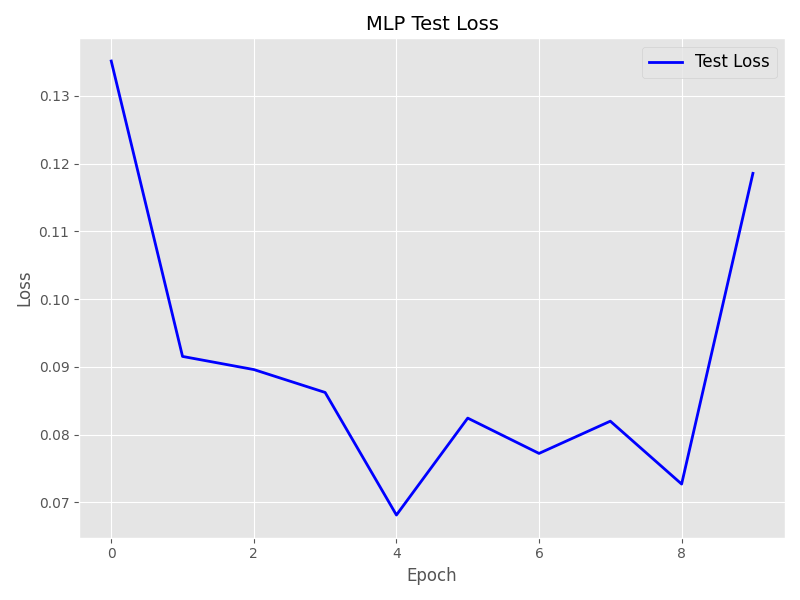

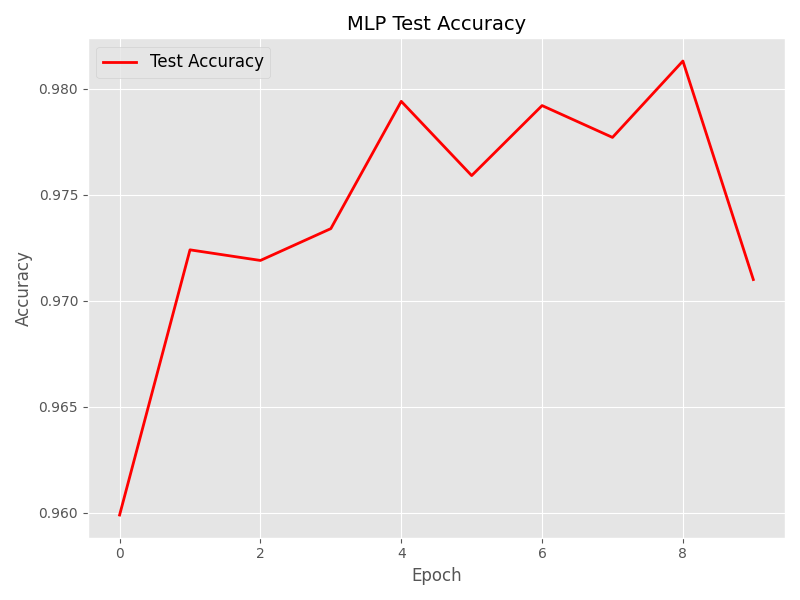

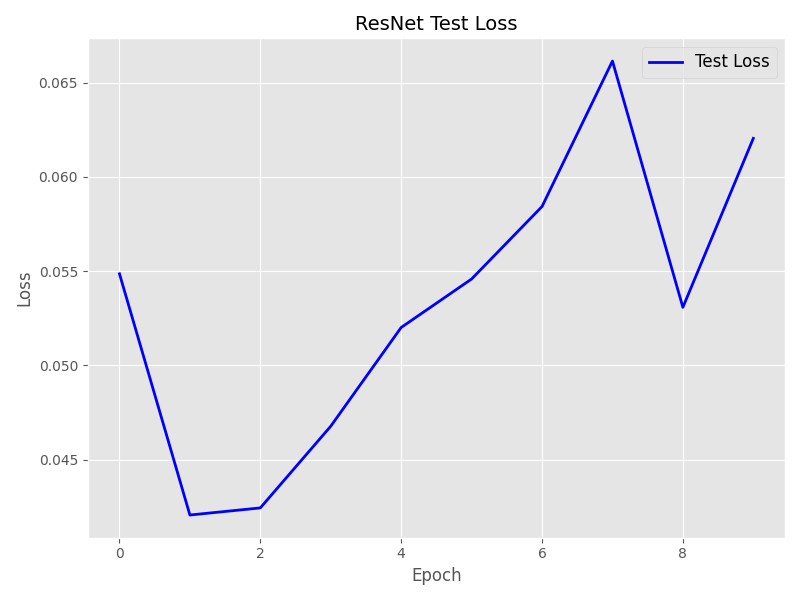

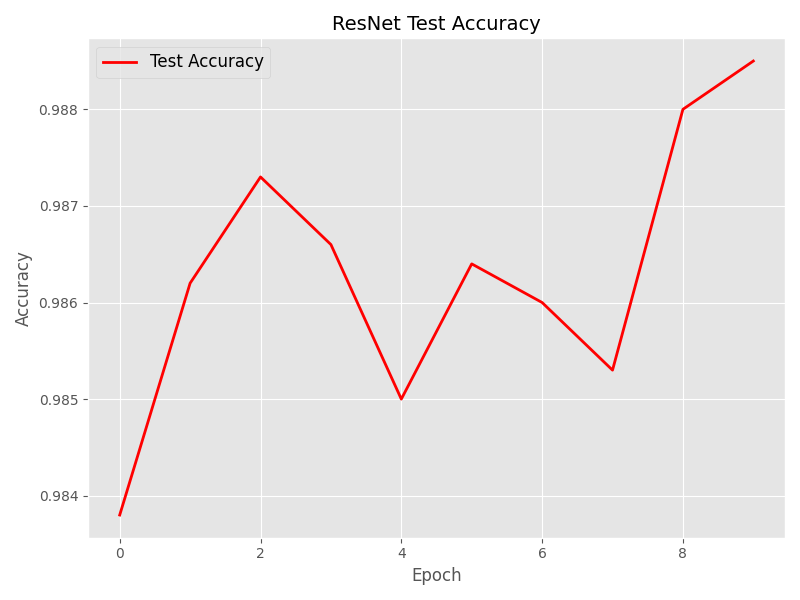

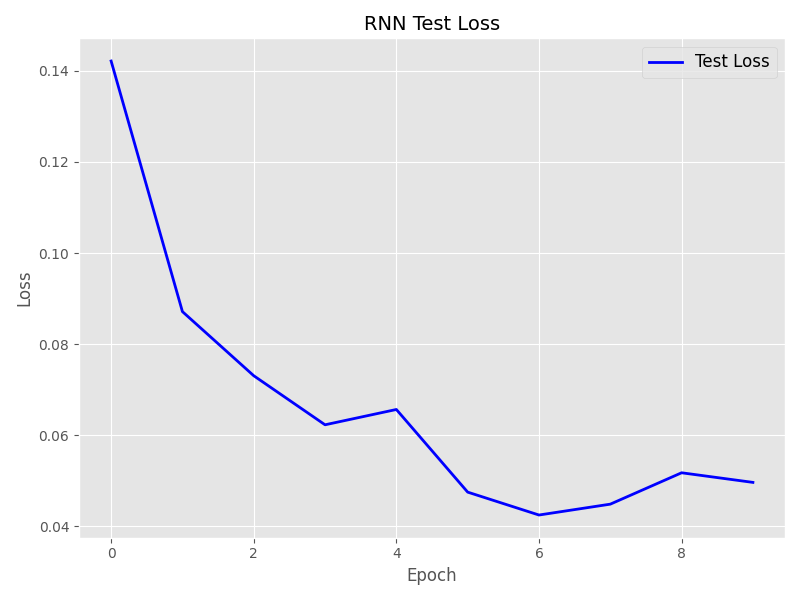

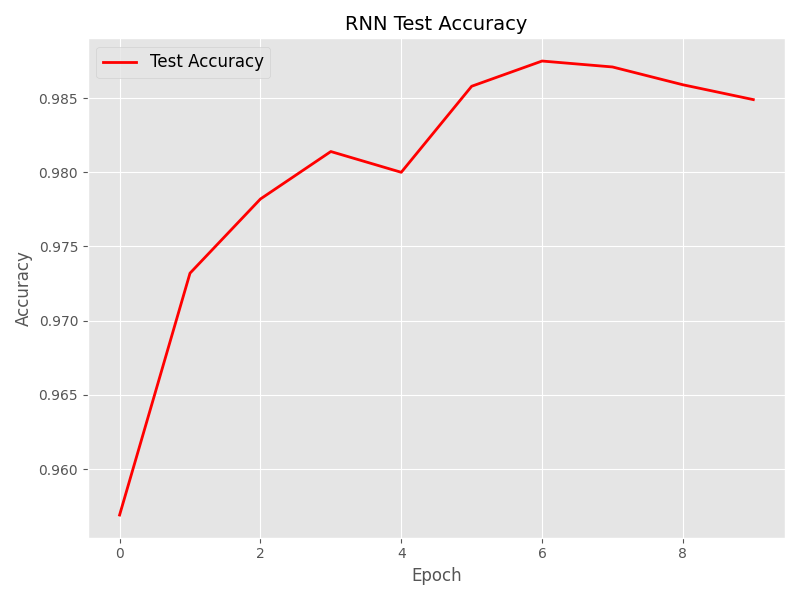

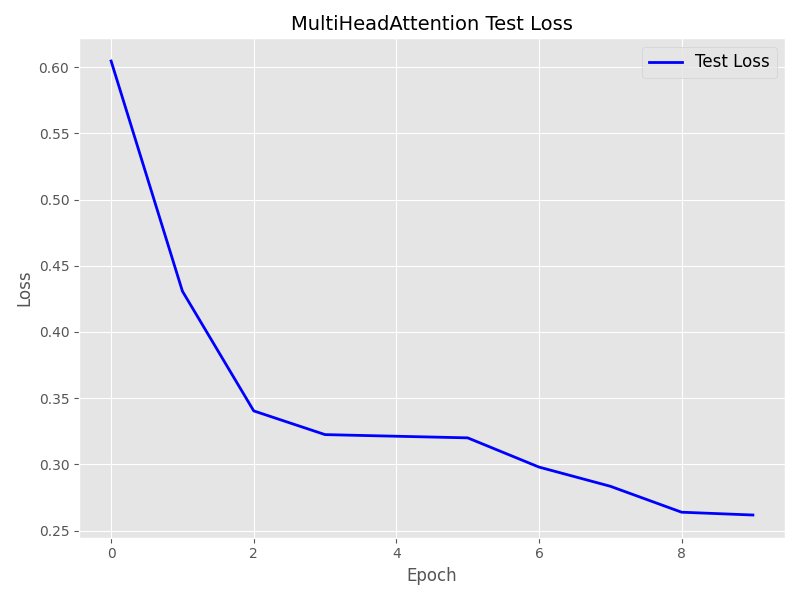

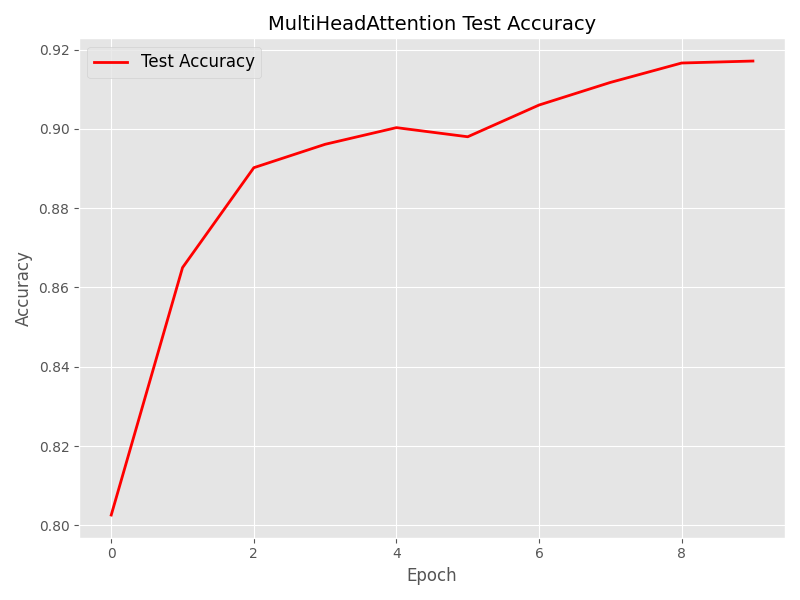

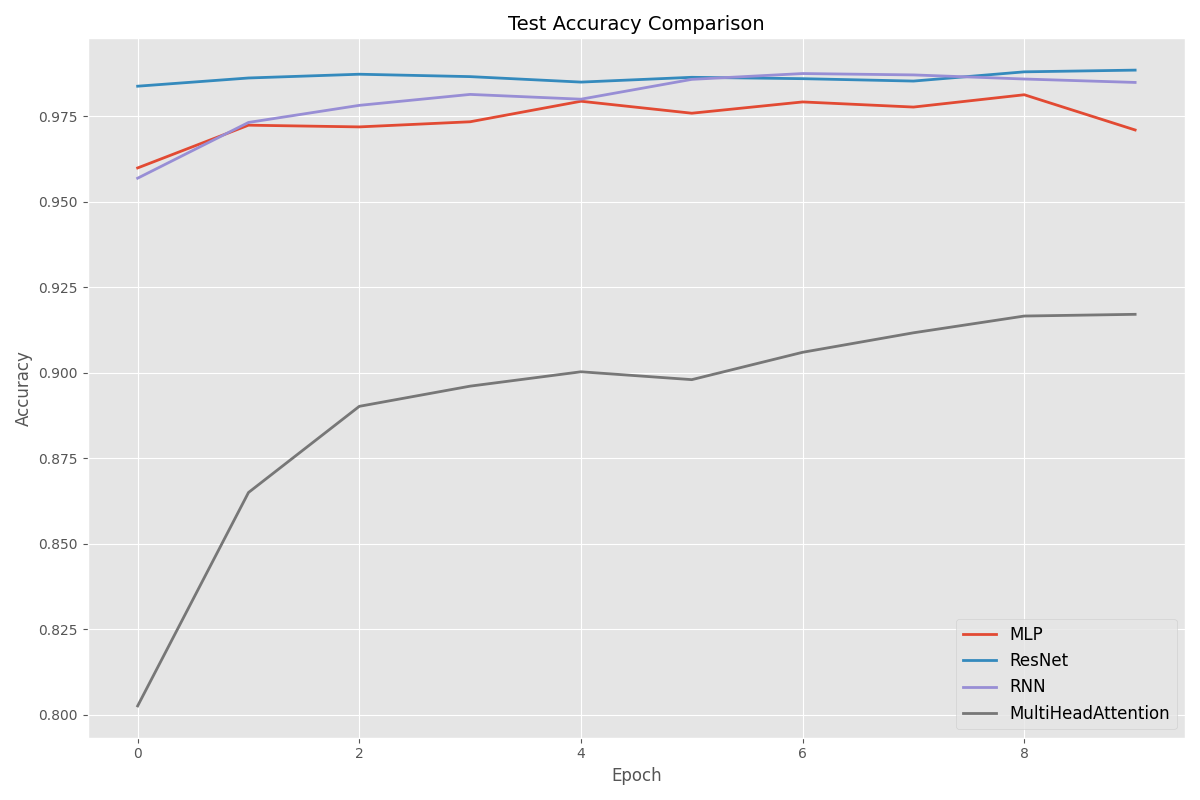

In [1]:
from IPython.display import Image, display
display(Image(filename='MLP_test_loss.png'))
display(Image(filename='MLP_test_accuracy.png'))
display(Image(filename='ResNet_test_loss.png'))
display(Image(filename='ResNet_test_accuracy.png'))
display(Image(filename='RNN_test_loss.png'))
display(Image(filename='RNN_test_accuracy.png'))
display(Image(filename='MultiHeadAttention_test_loss.png'))
display(Image(filename='MultiHeadAttention_test_accuracy.png'))
display(Image(filename='model_comparison.png'))
